In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import ROOT
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import os
import sys
import hickle
# import seaborn as sns

Welcome to JupyROOT 6.12/06


In [2]:
sys.path.insert(0, '../../allpixAnalysis/')
sys.path.insert(0, '../../getConversionFactors/')
import plotChargeHisto as pch
import getConversionFactors_ROOT as gcfr

## Load Data

In [3]:
# Deconv data
deconv_data_hck = 'vacreco_data_N.hck'
'''
deconv_data_single_hck = 'vacreco_data_single'
deconv_data_square_hck = 'vacreco_data_square'
deconv_data_N_hck = 'vacreco_data_N'
'''

d = hickle.load(deconv_data_hck)
bins = d['bins']
N_hists = d['N']
deconv_data, deconv_data_true = d['deconv_data'], d['deconv_data_true']
deconv_data_test, deconv_data_true_test = d['deconv_data_test'], d['deconv_data_true_test']

## Settings

In [4]:
TRUE_BINNING = True
if TRUE_BINNING:
    binEdges = {'vac': [12, 18, 21, 24.5, 33.5, 43, 53.5, 66.5, 81.5, 97, 113, 131.5, 151.5, 173, 200.5, 236, 430],
        'sn': [32, 37, 47, 57.5, 68.5, 80, 91.5, 104, 117, 131, 145, 163.5, 183.5, 207.5, 234.5, 269.5, 430],
        'al': [12, 17, 31, 40, 45.5, 50.5, 60.5, 68, 91, 102.5, 133, 148, 163, 196, 220, 257, 430]}
    
    OUTPUT_LENGTH = 16
else:
    OUTPUT_LENGTH = len(bins) - 1

## Model Definition

In [5]:
## Model Definition
def add_hidden_layer_summary(value):
  tf.summary.scalar('fraction_of_zero_values', tf.nn.zero_fraction(value))
  tf.summary.histogram('activation', value)

def encoder(inputs, hidden_units, dropout, is_training):
    net = inputs
    for num_hidden_units in hidden_units:
        net = tf.contrib.layers.fully_connected(
            net, num_outputs=num_hidden_units)
        if dropout is not None:
            net = slim.dropout(net, is_training=is_training)
        add_hidden_layer_summary(net)
    return net
  
def conv_encoder(inputs, hidden_units, dropout, scope=None):
    net = inputs
    with tf.variable_scope(scope, 'encoder', [inputs]):
        for layer_id, num_outputs in enumerate(hidden_units):
            with tf.variable_scope('block{}'.format(layer_id)):
                # net = slim.repeat(net, 2, tf.layers.conv1d, filters=num_outputs,
                #                  kernel_size=3, padding="SAME")
                net = tf.layers.conv1d(net, filters=num_outputs, kernel_size=3, padding="SAME")
                # net = tf.contrib.layers.max_pool2d(net, kernel_size=2)
 
        net = tf.identity(net, name='output')
    return net

def decoder(inputs, hidden_units, dropout, is_training):
    net = inputs
    for num_hidden_units in hidden_units[:-1]:
        net = tf.contrib.layers.fully_connected(
            net, num_outputs=num_hidden_units)
        if dropout is not None:
            net = slim.dropout(net, is_training=is_training)
        add_hidden_layer_summary(net)
 
    net = tf.contrib.layers.fully_connected(net, hidden_units[-1], activation_fn=None)
    tf.summary.histogram('activation', net)
    return net
  
def conv_decoder(inputs, hidden_units, dropout, scope=None, batch_size=100, output_length=149):
    net = inputs
    with tf.variable_scope(scope, 'decoder', [inputs]):
        print hidden_units
        for layer_id, num_outputs in enumerate(hidden_units[:-1]):
            with tf.variable_scope('block_{}'.format(layer_id),
                                   values=(net,)):
                net = tf.contrib.nn.conv1d_transpose(net, tf.Variable(tf.random_normal([3, hidden_units[layer_id+1], num_outputs], dtype=tf.float32)), [batch_size, 1, hidden_units[layer_id+1]], 1, padding='SAME')

        with tf.variable_scope('linear', values=(net,)):
            net = tf.contrib.nn.conv1d_transpose(net, tf.Variable(tf.random_normal([1, output_length, hidden_units[-1]], dtype=tf.float32)), [batch_size, 1, output_length], 1, padding='SAME')
              
        # net = tf.nn.relu(net) # 
        net = tf.layers.dense(inputs=net, units=output_length, activation=None)
        net = tf.abs(net)
        print(net)

    return net

def autoencoder(inputs, hidden_units, activation_fn, dropout, weight_decay, mode, output_length):
    is_training = (mode == tf.estimator.ModeKeys.TRAIN)
 
    weights_init = slim.initializers.variance_scaling_initializer()
    if weight_decay is None:
        weights_reg = None
    else:
        weights_reg = tf.contrib.layers.l2_regularizer(weight_decay)
 
    with slim.arg_scope([tf.contrib.layers.fully_connected],
                        weights_initializer=weights_init,
                        weights_regularizer=weights_reg,
                        activation_fn=activation_fn):
        print inputs, output_length
        batch_size, data_length = inputs.get_shape()
        if mode == tf.estimator.ModeKeys.EVAL or mode == tf.estimator.ModeKeys.PREDICT:
            batch_size = BINS_EVAL
            
        inputs = tf.reshape(inputs, [-1, 1, data_length])
        net = conv_encoder(inputs, hidden_units[0], None, None)
        net = conv_decoder(net, hidden_units[1], None, None, int(batch_size), output_length)
        net = tf.reshape(net, [-1, output_length])
          
    return net

encoder_hidden_units = [128, 128, 128] # [32, 32, 32, 32]
decoder_hidden_units = [128, 128, 128] # [32, 32, 32, 32]
activation_fn = None
dropout = None
weight_decay = 1e-5
learning_rate=0.001
# learning_rate=1.e-5

def model_fn(features, labels, mode, params={'hidden_units': [128, 64, 32], 'activation_fn': None, 'dropout': None, 'weight_decay': 1.e-5, 'learning_rate': 0.001}):
    # hidden_units = params['hidden_units']
    # activation_fn = params['activiation_fn']
    # dropout = params['dropout']
    # weight_decay = params['weight_decay']
    # learning_rate = params['learning_rate']

    if not mode == tf.estimator.ModeKeys.PREDICT:
        output_length = int(labels.get_shape()[-1])
    else:
        output_length = OUTPUT_LENGTH
    logits = autoencoder(inputs=tf.cast(features['x'], dtype=tf.float32),
        hidden_units=(encoder_hidden_units, decoder_hidden_units),
        activation_fn=activation_fn,
        dropout=dropout,
        weight_decay=weight_decay,
        mode=mode,
        output_length=output_length)
  
    probs = logits # tf.nn.sigmoid(logits)
    predictions = {"prediction": probs}
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(
            mode=mode,
            predictions=predictions)

    print labels
    print logits
    tf.losses.mean_squared_error(labels, logits) # sigmoid_cross_entropy(labels, logits)
    total_loss = tf.losses.get_total_loss(add_regularization_losses=(mode == tf.estimator.ModeKeys.TRAIN))

    if mode == tf.estimator.ModeKeys.TRAIN:
        train_op = tf.contrib.layers.optimize_loss(
            loss=total_loss,
            optimizer="Adam",
            learning_rate=learning_rate,
            learning_rate_decay_fn=lambda lr, gs: tf.train.exponential_decay(lr, gs, 1000, 0.96, staircase=True),
            global_step=tf.train.get_global_step(),
            summaries=["learning_rate", "global_gradient_norm"])
    else:
        train_op = None
 
    # Add histograms for trainable variables
    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name, var)

    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metric_ops = {
            "rmse": tf.metrics.root_mean_squared_error(
                tf.cast(labels, tf.float64), tf.cast(probs, tf.float64))
        }
    else:
        eval_metric_ops = None

    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=predictions,
        loss=total_loss,
        train_op=train_op,
        eval_metric_ops=eval_metric_ops)

In [6]:
run_config = tf.estimator.RunConfig(save_checkpoints_steps=1000,
                                    save_summary_steps=20)

estimator = tf.estimator.Estimator(model_fn=model_fn, 
                                   model_dir='model_dir/modelAEelectron1/',
                                   config=run_config)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f941ffb83d0>, '_save_checkpoints_steps': 1000, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'model_dir/modelAEelectron1/', '_save_summary_steps': 20}


## Training

In [21]:
x = {'x': np.hstack((deconv_data['al'], deconv_data['sn']))}
y = np.asarray(deconv_data['vac'])
x_eval = {'x': np.hstack((deconv_data_test['al'], deconv_data_test['sn']))}
y_eval = np.asarray(deconv_data_test['vac'])
# x = {'x': np.hstack((np.asarray(hist_list_al), np.asarray(hist_list_sn)))}
# y = np.asarray(hist_list_vac)
# x_eval = {'x': np.hstack((np.asarray(hist_list_test_al), np.asarray(hist_list_test_sn)))}
# y_eval = np.asarray(hist_list_test_vac)

BINS_EVAL = 100
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=x,
    y=y,
    batch_size=100,
    num_epochs=None,
    shuffle=True)
train_spec = tf.estimator.TrainSpec(
    input_fn=train_input_fn, 
    max_steps=600000)

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=x_eval,
    y=y_eval,
    num_epochs=1,
    batch_size=100,
    shuffle=False)
eval_spec = tf.estimator.EvalSpec(
    input_fn=eval_input_fn, 
    steps=100,
    start_delay_secs=60,
    throttle_secs=60)

tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 60 secs (eval_spec.throttle_secs) or training is finished.
Tensor("Cast:0", shape=(100, 32), dtype=float32) 16
[128, 128, 128]
Tensor("decoder/Abs:0", shape=(100, 1, 16), dtype=float32)
Tensor("random_shuffle_queue_DequeueMany:2", shape=(100, 16), dtype=float64, device=/device:CPU:0)
Tensor("Reshape_1:0", shape=(100, 16), dtype=float32)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from model_dir/modelAEelectron1/model.ckpt-299856
INFO:tensorflow:Saving checkpoints for 299857 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorflow:loss = 0.0005676183, step = 299857
INFO:tensorflow:global_step/sec: 42.0773
INFO:tensorflow:loss = 0.00070587173, step = 299957 (2.381 sec)
INFO:tensorflow:global_step/sec: 41.2826
INFO:tensorflow:loss = 0.0006131675, step = 300057 (2.419 sec)
INFO:tensorflow:global_step

INFO:tensorflow:loss = 0.0005996837, step = 305469 (1.892 sec)
INFO:tensorflow:global_step/sec: 54.5598
INFO:tensorflow:loss = 0.00068423187, step = 305569 (1.832 sec)
INFO:tensorflow:Saving checkpoints for 305669 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorflow:global_step/sec: 43.3705
INFO:tensorflow:loss = 0.00078083784, step = 305669 (2.321 sec)
INFO:tensorflow:Saving checkpoints for 305754 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00065058545.
Tensor("Cast:0", shape=(?, 32), dtype=float32) 16
[128, 128, 128]
Tensor("decoder/Abs:0", shape=(100, 1, 16), dtype=float32)
Tensor("fifo_queue_DequeueUpTo:2", shape=(?, 16), dtype=float64, device=/device:CPU:0)
Tensor("Reshape_1:0", shape=(100, 16), dtype=float32)
INFO:tensorflow:Starting evaluation at 2018-11-05-21:16:15
INFO:tensorflow:Restoring parameters from model_dir/modelAEelectron1/model.ckpt-305754
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Finished evaluation at 2018-11-

INFO:tensorflow:loss = 0.00083526544, step = 310488 (2.119 sec)
INFO:tensorflow:global_step/sec: 46.0532
INFO:tensorflow:loss = 0.0005279184, step = 310588 (2.172 sec)
INFO:tensorflow:global_step/sec: 46.2823
INFO:tensorflow:loss = 0.0010929487, step = 310688 (2.159 sec)
INFO:tensorflow:global_step/sec: 46.6298
INFO:tensorflow:loss = 0.0008979481, step = 310788 (2.145 sec)
INFO:tensorflow:Saving checkpoints for 310821 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0009839573.
Tensor("Cast:0", shape=(?, 32), dtype=float32) 16
[128, 128, 128]
Tensor("decoder/Abs:0", shape=(100, 1, 16), dtype=float32)
Tensor("fifo_queue_DequeueUpTo:2", shape=(?, 16), dtype=float64, device=/device:CPU:0)
Tensor("Reshape_1:0", shape=(100, 16), dtype=float32)
INFO:tensorflow:Starting evaluation at 2018-11-05-21:18:18
INFO:tensorflow:Restoring parameters from model_dir/modelAEelectron1/model.ckpt-310821
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Finished evaluation

INFO:tensorflow:loss = 0.0005684367, step = 315587 (2.206 sec)
INFO:tensorflow:global_step/sec: 45.5547
INFO:tensorflow:loss = 0.0009170249, step = 315687 (2.195 sec)
INFO:tensorflow:global_step/sec: 45.7347
INFO:tensorflow:loss = 0.0009383276, step = 315787 (2.187 sec)
INFO:tensorflow:global_step/sec: 43.5569
INFO:tensorflow:loss = 0.00049878267, step = 315887 (2.298 sec)
INFO:tensorflow:Saving checkpoints for 315971 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0007070266.
Tensor("Cast:0", shape=(?, 32), dtype=float32) 16
[128, 128, 128]
Tensor("decoder/Abs:0", shape=(100, 1, 16), dtype=float32)
Tensor("fifo_queue_DequeueUpTo:2", shape=(?, 16), dtype=float64, device=/device:CPU:0)
Tensor("Reshape_1:0", shape=(100, 16), dtype=float32)
INFO:tensorflow:Starting evaluation at 2018-11-05-21:20:22
INFO:tensorflow:Restoring parameters from model_dir/modelAEelectron1/model.ckpt-315971
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Finished evaluation

INFO:tensorflow:loss = 0.0007021113, step = 320742 (2.256 sec)
INFO:tensorflow:global_step/sec: 45.7276
INFO:tensorflow:loss = 0.0005147594, step = 320842 (2.186 sec)
INFO:tensorflow:global_step/sec: 46.3044
INFO:tensorflow:loss = 0.0004491627, step = 320942 (2.159 sec)
INFO:tensorflow:global_step/sec: 45.5134
INFO:tensorflow:loss = 0.0007522536, step = 321042 (2.197 sec)
INFO:tensorflow:global_step/sec: 46.0214
INFO:tensorflow:loss = 0.00038074536, step = 321142 (2.174 sec)
INFO:tensorflow:Saving checkpoints for 321164 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0005831228.
Tensor("Cast:0", shape=(?, 32), dtype=float32) 16
[128, 128, 128]
Tensor("decoder/Abs:0", shape=(100, 1, 16), dtype=float32)
Tensor("fifo_queue_DequeueUpTo:2", shape=(?, 16), dtype=float64, device=/device:CPU:0)
Tensor("Reshape_1:0", shape=(100, 16), dtype=float32)
INFO:tensorflow:Starting evaluation at 2018-11-05-21:22:25
INFO:tensorflow:Restoring parameters from model_dir/mo

INFO:tensorflow:loss = 0.00092385034, step = 325839 (1.857 sec)
INFO:tensorflow:global_step/sec: 53.7981
INFO:tensorflow:loss = 0.0010416533, step = 325939 (1.859 sec)
INFO:tensorflow:global_step/sec: 51.3897
INFO:tensorflow:loss = 0.0008369307, step = 326039 (1.946 sec)
INFO:tensorflow:global_step/sec: 54.1384
INFO:tensorflow:loss = 0.00086180546, step = 326139 (1.847 sec)
INFO:tensorflow:global_step/sec: 54.3716
INFO:tensorflow:loss = 0.00074050925, step = 326239 (1.839 sec)
INFO:tensorflow:global_step/sec: 53.6896
INFO:tensorflow:loss = 0.00045166822, step = 326339 (1.862 sec)
INFO:tensorflow:Saving checkpoints for 326422 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0006318181.
Tensor("Cast:0", shape=(?, 32), dtype=float32) 16
[128, 128, 128]
Tensor("decoder/Abs:0", shape=(100, 1, 16), dtype=float32)
Tensor("fifo_queue_DequeueUpTo:2", shape=(?, 16), dtype=float64, device=/device:CPU:0)
Tensor("Reshape_1:0", shape=(100, 16), dtype=float32)
INFO:t

INFO:tensorflow:loss = 0.00040754682, step = 330956 (1.847 sec)
INFO:tensorflow:global_step/sec: 53.7414
INFO:tensorflow:loss = 0.00051041367, step = 331056 (1.861 sec)
INFO:tensorflow:global_step/sec: 54.1687
INFO:tensorflow:loss = 0.0007869984, step = 331156 (1.846 sec)
INFO:tensorflow:global_step/sec: 54.534
INFO:tensorflow:loss = 0.0007086812, step = 331256 (1.834 sec)
INFO:tensorflow:global_step/sec: 54.0109
INFO:tensorflow:loss = 0.0007476914, step = 331356 (1.852 sec)
INFO:tensorflow:Saving checkpoints for 331456 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorflow:global_step/sec: 49.5655
INFO:tensorflow:loss = 0.0005469044, step = 331456 (2.029 sec)
INFO:tensorflow:global_step/sec: 53.3541
INFO:tensorflow:loss = 0.00072373793, step = 331556 (1.863 sec)
INFO:tensorflow:global_step/sec: 51.9715
INFO:tensorflow:loss = 0.000606533, step = 331656 (1.924 sec)
INFO:tensorflow:global_step/sec: 49.9836
INFO:tensorflow:loss = 0.0008300982, step = 331756 (2.001 sec)
INFO:tensorflo

INFO:tensorflow:loss = 0.0008483207, step = 336026 (2.556 sec)
INFO:tensorflow:global_step/sec: 45.0792
INFO:tensorflow:loss = 0.0006763154, step = 336126 (2.216 sec)
INFO:tensorflow:Saving checkpoints for 336226 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorflow:global_step/sec: 43.8482
INFO:tensorflow:loss = 0.0004147028, step = 336226 (2.294 sec)
INFO:tensorflow:global_step/sec: 46.0133
INFO:tensorflow:loss = 0.00046416905, step = 336326 (2.160 sec)
INFO:tensorflow:global_step/sec: 45.9528
INFO:tensorflow:loss = 0.00063550123, step = 336426 (2.177 sec)
INFO:tensorflow:global_step/sec: 46.6515
INFO:tensorflow:loss = 0.00085316447, step = 336526 (2.144 sec)
INFO:tensorflow:global_step/sec: 46.1911
INFO:tensorflow:loss = 0.0005259046, step = 336626 (2.163 sec)
INFO:tensorflow:global_step/sec: 45.9379
INFO:tensorflow:loss = 0.0005374658, step = 336726 (2.177 sec)
INFO:tensorflow:global_step/sec: 45.9022
INFO:tensorflow:loss = 0.0004970209, step = 336826 (2.179 sec)
INFO:tensorf

INFO:tensorflow:loss = 0.00055606593, step = 341039 (2.076 sec)
INFO:tensorflow:global_step/sec: 48.6818
INFO:tensorflow:loss = 0.0008657386, step = 341139 (2.054 sec)
INFO:tensorflow:global_step/sec: 48.7444
INFO:tensorflow:loss = 0.00058809185, step = 341239 (2.054 sec)
INFO:tensorflow:global_step/sec: 48.9816
INFO:tensorflow:loss = 0.0006958701, step = 341339 (2.039 sec)
INFO:tensorflow:Saving checkpoints for 341439 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorflow:global_step/sec: 43.5035
INFO:tensorflow:loss = 0.0006854593, step = 341439 (2.316 sec)
INFO:tensorflow:global_step/sec: 44.9243
INFO:tensorflow:loss = 0.00044491875, step = 341539 (2.209 sec)
INFO:tensorflow:global_step/sec: 50.093
INFO:tensorflow:loss = 0.0008459172, step = 341639 (1.996 sec)
INFO:tensorflow:global_step/sec: 50.0506
INFO:tensorflow:loss = 0.0005860219, step = 341739 (1.998 sec)
INFO:tensorflow:global_step/sec: 50.3053
INFO:tensorflow:loss = 0.0007842432, step = 341839 (1.990 sec)
INFO:tensorfl

INFO:tensorflow:loss = 0.0005609499, step = 346138 (2.306 sec)
INFO:tensorflow:global_step/sec: 41.9847
INFO:tensorflow:loss = 0.00062108797, step = 346238 (2.385 sec)
INFO:tensorflow:global_step/sec: 42.6243
INFO:tensorflow:loss = 0.0006505842, step = 346338 (2.343 sec)
INFO:tensorflow:Saving checkpoints for 346438 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorflow:global_step/sec: 39.577
INFO:tensorflow:loss = 0.0011389237, step = 346438 (2.541 sec)
INFO:tensorflow:global_step/sec: 47.244
INFO:tensorflow:loss = 0.00046569444, step = 346538 (2.103 sec)
INFO:tensorflow:global_step/sec: 46.3472
INFO:tensorflow:loss = 0.00067078706, step = 346638 (2.157 sec)
INFO:tensorflow:global_step/sec: 43.9592
INFO:tensorflow:loss = 0.0004524594, step = 346738 (2.278 sec)
INFO:tensorflow:global_step/sec: 46.7781
INFO:tensorflow:loss = 0.0009027375, step = 346838 (2.135 sec)
INFO:tensorflow:global_step/sec: 46.5994
INFO:tensorflow:loss = 0.00050525396, step = 346938 (2.146 sec)
INFO:tensorfl

INFO:tensorflow:loss = 0.0006663738, step = 351215 (2.287 sec)
INFO:tensorflow:global_step/sec: 43.6628
INFO:tensorflow:loss = 0.0010045766, step = 351315 (2.289 sec)
INFO:tensorflow:global_step/sec: 43.4902
INFO:tensorflow:loss = 0.00046518844, step = 351415 (2.300 sec)
INFO:tensorflow:global_step/sec: 44.4262
INFO:tensorflow:loss = 0.00088429864, step = 351515 (2.251 sec)
INFO:tensorflow:Saving checkpoints for 351615 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorflow:global_step/sec: 44.0376
INFO:tensorflow:loss = 0.0006634718, step = 351615 (2.285 sec)
INFO:tensorflow:global_step/sec: 47.123
INFO:tensorflow:loss = 0.0007623411, step = 351715 (2.109 sec)
INFO:tensorflow:global_step/sec: 47.2131
INFO:tensorflow:loss = 0.00069650955, step = 351815 (2.118 sec)
INFO:tensorflow:global_step/sec: 47.2584
INFO:tensorflow:loss = 0.00084637635, step = 351915 (2.117 sec)
INFO:tensorflow:global_step/sec: 47.3384
INFO:tensorflow:loss = 0.0005893951, step = 352015 (2.112 sec)
INFO:tensorf

INFO:tensorflow:loss = 0.0007786135, step = 356351 (2.231 sec)
INFO:tensorflow:global_step/sec: 47.3906
INFO:tensorflow:loss = 0.0006944647, step = 356451 (2.110 sec)
INFO:tensorflow:global_step/sec: 46.8807
INFO:tensorflow:loss = 0.00046169787, step = 356551 (2.133 sec)
INFO:tensorflow:global_step/sec: 46.9333
INFO:tensorflow:loss = 0.00044897496, step = 356651 (2.131 sec)
INFO:tensorflow:global_step/sec: 44.0243
INFO:tensorflow:loss = 0.00085938215, step = 356751 (2.273 sec)
INFO:tensorflow:global_step/sec: 44.9735
INFO:tensorflow:loss = 0.00086457084, step = 356851 (2.223 sec)
INFO:tensorflow:Saving checkpoints for 356951 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorflow:global_step/sec: 43.2582
INFO:tensorflow:loss = 0.0006850217, step = 356951 (2.327 sec)
INFO:tensorflow:global_step/sec: 45.5728
INFO:tensorflow:loss = 0.00053381914, step = 357051 (2.178 sec)
INFO:tensorflow:global_step/sec: 42.2942
INFO:tensorflow:loss = 0.00069223274, step = 357151 (2.364 sec)
INFO:tens

INFO:tensorflow:loss = 0.0005657038, step = 361387 (2.212 sec)
INFO:tensorflow:global_step/sec: 41.4199
INFO:tensorflow:loss = 0.00092972367, step = 361487 (2.415 sec)
INFO:tensorflow:global_step/sec: 41.9002
INFO:tensorflow:loss = 0.00033660606, step = 361587 (2.389 sec)
INFO:tensorflow:global_step/sec: 43.7023
INFO:tensorflow:loss = 0.00044945415, step = 361687 (2.285 sec)
INFO:tensorflow:global_step/sec: 41.4135
INFO:tensorflow:loss = 0.0004859892, step = 361787 (2.415 sec)
INFO:tensorflow:global_step/sec: 46.1399
INFO:tensorflow:loss = 0.00038174793, step = 361887 (2.167 sec)
INFO:tensorflow:global_step/sec: 46.0391
INFO:tensorflow:loss = 0.0007885046, step = 361987 (2.175 sec)
INFO:tensorflow:Saving checkpoints for 362087 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorflow:global_step/sec: 38.5585
INFO:tensorflow:loss = 0.0007711839, step = 362087 (2.612 sec)
INFO:tensorflow:global_step/sec: 42.2086
INFO:tensorflow:loss = 0.00034798443, step = 362187 (2.348 sec)
INFO:tenso

INFO:tensorflow:loss = 0.0007502514, step = 366563 (2.232 sec)
INFO:tensorflow:global_step/sec: 46.1188
INFO:tensorflow:loss = 0.00044382742, step = 366663 (2.168 sec)
INFO:tensorflow:global_step/sec: 44.1055
INFO:tensorflow:loss = 0.00045429435, step = 366763 (2.268 sec)
INFO:tensorflow:global_step/sec: 44.4375
INFO:tensorflow:loss = 0.00041081337, step = 366863 (2.250 sec)
INFO:tensorflow:global_step/sec: 42.0903
INFO:tensorflow:loss = 0.00070600293, step = 366963 (2.376 sec)
INFO:tensorflow:global_step/sec: 42.9309
INFO:tensorflow:loss = 0.00047638096, step = 367063 (2.329 sec)
INFO:tensorflow:Saving checkpoints for 367163 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorflow:global_step/sec: 39.7928
INFO:tensorflow:loss = 0.00074801384, step = 367163 (2.525 sec)
INFO:tensorflow:global_step/sec: 45.9785
INFO:tensorflow:loss = 0.0008572465, step = 367263 (2.163 sec)
INFO:tensorflow:global_step/sec: 46.65
INFO:tensorflow:loss = 0.0009038657, step = 367363 (2.143 sec)
INFO:tensor

INFO:tensorflow:loss = 0.0005671557, step = 371633 (2.147 sec)
INFO:tensorflow:global_step/sec: 46.1959
INFO:tensorflow:loss = 0.000928068, step = 371733 (2.161 sec)
INFO:tensorflow:global_step/sec: 46.4543
INFO:tensorflow:loss = 0.00065864547, step = 371833 (2.154 sec)
INFO:tensorflow:global_step/sec: 45.5092
INFO:tensorflow:loss = 0.0004789156, step = 371933 (2.196 sec)
INFO:tensorflow:global_step/sec: 43.9649
INFO:tensorflow:loss = 0.00042139878, step = 372033 (2.275 sec)
INFO:tensorflow:global_step/sec: 42.3575
INFO:tensorflow:loss = 0.0005266817, step = 372133 (2.364 sec)
INFO:tensorflow:global_step/sec: 42.6026
INFO:tensorflow:loss = 0.00048547518, step = 372233 (2.344 sec)
INFO:tensorflow:Saving checkpoints for 372333 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorflow:global_step/sec: 39.6511
INFO:tensorflow:loss = 0.0008405831, step = 372333 (2.535 sec)
INFO:tensorflow:global_step/sec: 45.2037
INFO:tensorflow:loss = 0.00063911243, step = 372433 (2.199 sec)
INFO:tensorf

INFO:tensorflow:loss = 0.00053789304, step = 376708 (2.242 sec)
INFO:tensorflow:global_step/sec: 44.7694
INFO:tensorflow:loss = 0.0005864502, step = 376808 (2.233 sec)
INFO:tensorflow:global_step/sec: 46.7105
INFO:tensorflow:loss = 0.0006500067, step = 376908 (2.140 sec)
INFO:tensorflow:global_step/sec: 46.1714
INFO:tensorflow:loss = 0.00047939637, step = 377008 (2.166 sec)
INFO:tensorflow:global_step/sec: 42.6516
INFO:tensorflow:loss = 0.0006930233, step = 377108 (2.347 sec)
INFO:tensorflow:global_step/sec: 45.138
INFO:tensorflow:loss = 0.00053007103, step = 377208 (2.213 sec)
INFO:tensorflow:global_step/sec: 43.342
INFO:tensorflow:loss = 0.0005478094, step = 377308 (2.307 sec)
INFO:tensorflow:global_step/sec: 46.4225
INFO:tensorflow:loss = 0.0005047027, step = 377408 (2.154 sec)
INFO:tensorflow:Saving checkpoints for 377508 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorflow:global_step/sec: 42.9388
INFO:tensorflow:loss = 0.000767481, step = 377508 (2.342 sec)
INFO:tensorflow

INFO:tensorflow:loss = 0.0009435817, step = 381789 (2.349 sec)
INFO:tensorflow:global_step/sec: 45.8558
INFO:tensorflow:loss = 0.00060068024, step = 381889 (2.180 sec)
INFO:tensorflow:global_step/sec: 47.6742
INFO:tensorflow:loss = 0.0006013967, step = 381989 (2.100 sec)
INFO:tensorflow:global_step/sec: 47.1538
INFO:tensorflow:loss = 0.0006398849, step = 382089 (2.123 sec)
INFO:tensorflow:global_step/sec: 46.3245
INFO:tensorflow:loss = 0.00065682357, step = 382189 (2.155 sec)
INFO:tensorflow:global_step/sec: 46.4373
INFO:tensorflow:loss = 0.00061771914, step = 382289 (2.153 sec)
INFO:tensorflow:global_step/sec: 46.5583
INFO:tensorflow:loss = 0.0004452305, step = 382389 (2.149 sec)
INFO:tensorflow:Saving checkpoints for 382489 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorflow:global_step/sec: 42.3408
INFO:tensorflow:loss = 0.0011115127, step = 382489 (2.374 sec)
INFO:tensorflow:global_step/sec: 43.2529
INFO:tensorflow:loss = 0.00053020724, step = 382589 (2.298 sec)
INFO:tensor

INFO:tensorflow:loss = 0.00072334136, step = 386792 (2.621 sec)
INFO:tensorflow:global_step/sec: 41.7128
INFO:tensorflow:loss = 0.0003423052, step = 386892 (2.397 sec)
INFO:tensorflow:global_step/sec: 42.526
INFO:tensorflow:loss = 0.00074223813, step = 386992 (2.352 sec)
INFO:tensorflow:global_step/sec: 43.6474
INFO:tensorflow:loss = 0.0005981817, step = 387092 (2.291 sec)
INFO:tensorflow:global_step/sec: 42.1148
INFO:tensorflow:loss = 0.00046091317, step = 387192 (2.375 sec)
INFO:tensorflow:global_step/sec: 46.8234
INFO:tensorflow:loss = 0.00063184195, step = 387292 (2.135 sec)
INFO:tensorflow:global_step/sec: 46.3464
INFO:tensorflow:loss = 0.0004952555, step = 387392 (2.158 sec)
INFO:tensorflow:global_step/sec: 46.0783
INFO:tensorflow:loss = 0.00046028884, step = 387492 (2.174 sec)
INFO:tensorflow:global_step/sec: 44.5991
INFO:tensorflow:loss = 0.00049099204, step = 387592 (2.238 sec)
INFO:tensorflow:Saving checkpoints for 387692 into model_dir/modelAEelectron1/model.ckpt.
INFO:tenso

INFO:tensorflow:loss = 0.0007332077, step = 391962 (2.540 sec)
INFO:tensorflow:global_step/sec: 43.438
INFO:tensorflow:loss = 0.00045083268, step = 392062 (2.302 sec)
INFO:tensorflow:global_step/sec: 46.0105
INFO:tensorflow:loss = 0.00063752796, step = 392162 (2.173 sec)
INFO:tensorflow:global_step/sec: 46.9721
INFO:tensorflow:loss = 0.00054702413, step = 392262 (2.129 sec)
INFO:tensorflow:global_step/sec: 47.4388
INFO:tensorflow:loss = 0.000318406, step = 392362 (2.108 sec)
INFO:tensorflow:global_step/sec: 47.1624
INFO:tensorflow:loss = 0.0007522733, step = 392462 (2.120 sec)
INFO:tensorflow:global_step/sec: 47.4566
INFO:tensorflow:loss = 0.0006545179, step = 392562 (2.108 sec)
INFO:tensorflow:global_step/sec: 44.6164
INFO:tensorflow:loss = 0.0008981506, step = 392662 (2.240 sec)
INFO:tensorflow:global_step/sec: 38.8339
INFO:tensorflow:loss = 0.00047923496, step = 392762 (2.576 sec)
INFO:tensorflow:Saving checkpoints for 392862 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorfl

INFO:tensorflow:loss = 0.00052196847, step = 397119 (2.170 sec)
INFO:tensorflow:global_step/sec: 44.3263
INFO:tensorflow:loss = 0.00079869624, step = 397219 (2.256 sec)
INFO:tensorflow:global_step/sec: 43.2452
INFO:tensorflow:loss = 0.00041520162, step = 397319 (2.313 sec)
INFO:tensorflow:global_step/sec: 44.7656
INFO:tensorflow:loss = 0.0007876924, step = 397419 (2.233 sec)
INFO:tensorflow:global_step/sec: 42.5942
INFO:tensorflow:loss = 0.000500207, step = 397519 (2.351 sec)
INFO:tensorflow:global_step/sec: 44.1738
INFO:tensorflow:loss = 0.00041013316, step = 397619 (2.261 sec)
INFO:tensorflow:global_step/sec: 46.129
INFO:tensorflow:loss = 0.0006251419, step = 397719 (2.168 sec)
INFO:tensorflow:global_step/sec: 41.9399
INFO:tensorflow:loss = 0.00036496698, step = 397819 (2.384 sec)
INFO:tensorflow:Saving checkpoints for 397919 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorflow:global_step/sec: 42.6473
INFO:tensorflow:loss = 0.0005294096, step = 397919 (2.357 sec)
INFO:tensorf

INFO:tensorflow:loss = 0.0005284531, step = 402170 (2.344 sec)
INFO:tensorflow:global_step/sec: 45.9986
INFO:tensorflow:loss = 0.00064353336, step = 402270 (2.174 sec)
INFO:tensorflow:global_step/sec: 46.5923
INFO:tensorflow:loss = 0.0008562596, step = 402370 (2.146 sec)
INFO:tensorflow:global_step/sec: 45.9124
INFO:tensorflow:loss = 0.0010170257, step = 402470 (2.181 sec)
INFO:tensorflow:global_step/sec: 45.7409
INFO:tensorflow:loss = 0.00047010317, step = 402570 (2.184 sec)
INFO:tensorflow:global_step/sec: 46.538
INFO:tensorflow:loss = 0.0003955058, step = 402670 (2.149 sec)
INFO:tensorflow:global_step/sec: 46.5182
INFO:tensorflow:loss = 0.00078003574, step = 402770 (2.150 sec)
INFO:tensorflow:global_step/sec: 46.3015
INFO:tensorflow:loss = 0.00051139144, step = 402870 (2.159 sec)
INFO:tensorflow:global_step/sec: 45.9084
INFO:tensorflow:loss = 0.000449728, step = 402970 (2.178 sec)
INFO:tensorflow:Saving checkpoints for 403070 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorfl

INFO:tensorflow:loss = 0.0005300561, step = 407240 (2.292 sec)
INFO:tensorflow:global_step/sec: 47.8496
INFO:tensorflow:loss = 0.0005066674, step = 407340 (2.089 sec)
INFO:tensorflow:global_step/sec: 44.2213
INFO:tensorflow:loss = 0.0006463452, step = 407440 (2.263 sec)
INFO:tensorflow:global_step/sec: 47.2667
INFO:tensorflow:loss = 0.00057059637, step = 407540 (2.115 sec)
INFO:tensorflow:global_step/sec: 46.8212
INFO:tensorflow:loss = 0.00082055625, step = 407640 (2.136 sec)
INFO:tensorflow:global_step/sec: 45.2403
INFO:tensorflow:loss = 0.00037554099, step = 407740 (2.210 sec)
INFO:tensorflow:global_step/sec: 45.6427
INFO:tensorflow:loss = 0.00068230194, step = 407840 (2.192 sec)
INFO:tensorflow:global_step/sec: 46.9568
INFO:tensorflow:loss = 0.00074858573, step = 407940 (2.129 sec)
INFO:tensorflow:global_step/sec: 46.5827
INFO:tensorflow:loss = 0.0005792782, step = 408040 (2.148 sec)
INFO:tensorflow:Saving checkpoints for 408140 into model_dir/modelAEelectron1/model.ckpt.
INFO:tenso

INFO:tensorflow:loss = 0.0006374579, step = 412337
INFO:tensorflow:global_step/sec: 36.5349
INFO:tensorflow:loss = 0.0006781529, step = 412437 (2.740 sec)
INFO:tensorflow:global_step/sec: 44.185
INFO:tensorflow:loss = 0.000890422, step = 412537 (2.263 sec)
INFO:tensorflow:global_step/sec: 44.142
INFO:tensorflow:loss = 0.00069891347, step = 412637 (2.264 sec)
INFO:tensorflow:global_step/sec: 40.3187
INFO:tensorflow:loss = 0.0009003061, step = 412737 (2.482 sec)
INFO:tensorflow:global_step/sec: 41.8474
INFO:tensorflow:loss = 0.0010509738, step = 412837 (2.387 sec)
INFO:tensorflow:global_step/sec: 43.4135
INFO:tensorflow:loss = 0.00091658457, step = 412937 (2.304 sec)
INFO:tensorflow:global_step/sec: 42.6741
INFO:tensorflow:loss = 0.00047805725, step = 413037 (2.343 sec)
INFO:tensorflow:global_step/sec: 45.5891
INFO:tensorflow:loss = 0.00058799237, step = 413137 (2.192 sec)
INFO:tensorflow:global_step/sec: 45.1792
INFO:tensorflow:loss = 0.0007201224, step = 413237 (2.214 sec)
INFO:tensorf

INFO:tensorflow:global_step/sec: 44.9938
INFO:tensorflow:loss = 0.0005830291, step = 417592 (2.222 sec)
INFO:tensorflow:global_step/sec: 45.2306
INFO:tensorflow:loss = 0.0003956106, step = 417692 (2.211 sec)
INFO:tensorflow:global_step/sec: 41.6097
INFO:tensorflow:loss = 0.00058310624, step = 417792 (2.403 sec)
INFO:tensorflow:global_step/sec: 44.4114
INFO:tensorflow:loss = 0.0005831394, step = 417892 (2.252 sec)
INFO:tensorflow:global_step/sec: 45.2355
INFO:tensorflow:loss = 0.00037140175, step = 417992 (2.210 sec)
INFO:tensorflow:global_step/sec: 45.3081
INFO:tensorflow:loss = 0.0005522707, step = 418092 (2.208 sec)
INFO:tensorflow:Saving checkpoints for 418192 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorflow:global_step/sec: 41.7376
INFO:tensorflow:loss = 0.00062938203, step = 418192 (2.412 sec)
INFO:tensorflow:global_step/sec: 42.6751
INFO:tensorflow:loss = 0.00033017554, step = 418292 (2.330 sec)
INFO:tensorflow:global_step/sec: 42.7121
INFO:tensorflow:loss = 0.00036417

INFO:tensorflow:global_step/sec: 44.2651
INFO:tensorflow:loss = 0.0006792678, step = 422649 (2.259 sec)
INFO:tensorflow:global_step/sec: 43.7809
INFO:tensorflow:loss = 0.00078200083, step = 422749 (2.284 sec)
INFO:tensorflow:global_step/sec: 42.1819
INFO:tensorflow:loss = 0.0004404363, step = 422849 (2.372 sec)
INFO:tensorflow:global_step/sec: 42.6891
INFO:tensorflow:loss = 0.0010183173, step = 422949 (2.341 sec)
INFO:tensorflow:global_step/sec: 44.5635
INFO:tensorflow:loss = 0.00087748666, step = 423049 (2.246 sec)
INFO:tensorflow:Saving checkpoints for 423149 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorflow:global_step/sec: 41.1839
INFO:tensorflow:loss = 0.0012280223, step = 423149 (2.444 sec)
INFO:tensorflow:global_step/sec: 43.5499
INFO:tensorflow:loss = 0.0008397569, step = 423249 (2.280 sec)
INFO:tensorflow:global_step/sec: 44.2361
INFO:tensorflow:loss = 0.0009034345, step = 423349 (2.259 sec)
INFO:tensorflow:global_step/sec: 42.6795
INFO:tensorflow:loss = 0.0004373583

INFO:tensorflow:global_step/sec: 44.3149
INFO:tensorflow:loss = 0.0005573537, step = 427735 (2.257 sec)
INFO:tensorflow:global_step/sec: 39.6803
INFO:tensorflow:loss = 0.00053952285, step = 427835 (2.520 sec)
INFO:tensorflow:global_step/sec: 42.4321
INFO:tensorflow:loss = 0.000721409, step = 427935 (2.358 sec)
INFO:tensorflow:global_step/sec: 42.8462
INFO:tensorflow:loss = 0.00087139494, step = 428035 (2.333 sec)
INFO:tensorflow:Saving checkpoints for 428135 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorflow:global_step/sec: 39.7281
INFO:tensorflow:loss = 0.0005445967, step = 428135 (2.533 sec)
INFO:tensorflow:global_step/sec: 44.432
INFO:tensorflow:loss = 0.0009946073, step = 428235 (2.234 sec)
INFO:tensorflow:global_step/sec: 43.8033
INFO:tensorflow:loss = 0.0005500171, step = 428335 (2.283 sec)
INFO:tensorflow:global_step/sec: 44.1977
INFO:tensorflow:loss = 0.00065549824, step = 428435 (2.263 sec)
INFO:tensorflow:global_step/sec: 40.881
INFO:tensorflow:loss = 0.00081785826,

INFO:tensorflow:global_step/sec: 43.6849
INFO:tensorflow:loss = 0.00060610357, step = 432850 (2.293 sec)
INFO:tensorflow:global_step/sec: 39.5438
INFO:tensorflow:loss = 0.00064785377, step = 432950 (2.527 sec)
INFO:tensorflow:Saving checkpoints for 433050 into model_dir/modelAEelectron1/model.ckpt.
INFO:tensorflow:global_step/sec: 38.5012
INFO:tensorflow:loss = 0.00054711645, step = 433050 (2.610 sec)
INFO:tensorflow:global_step/sec: 37.0077
INFO:tensorflow:loss = 0.0006393282, step = 433150 (2.690 sec)
INFO:tensorflow:global_step/sec: 43.2246
INFO:tensorflow:loss = 0.0003943522, step = 433250 (2.312 sec)
INFO:tensorflow:global_step/sec: 45.7405
INFO:tensorflow:loss = 0.00087331753, step = 433350 (2.187 sec)
INFO:tensorflow:global_step/sec: 45.0348
INFO:tensorflow:loss = 0.00066014647, step = 433450 (2.219 sec)
INFO:tensorflow:global_step/sec: 44.7206
INFO:tensorflow:loss = 0.00084847107, step = 433550 (2.236 sec)
INFO:tensorflow:global_step/sec: 43.0209
INFO:tensorflow:loss = 0.000512

KeyboardInterrupt: 

## Evaluation

In [22]:
BINS_EVAL = 100
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=x_eval,
    y=y_eval,
    num_epochs=1,
    batch_size=100,
    shuffle=False)

eval_results = estimator.evaluate(input_fn=eval_input_fn) # , hooks=[train_input_fn.init_hook])
print(eval_results)

Tensor("Cast:0", shape=(?, 32), dtype=float32) 16
[128, 128, 128]
Tensor("decoder/Abs:0", shape=(100, 1, 16), dtype=float32)
Tensor("fifo_queue_DequeueUpTo:2", shape=(?, 16), dtype=float64, device=/device:CPU:0)
Tensor("Reshape_1:0", shape=(100, 16), dtype=float32)
INFO:tensorflow:Starting evaluation at 2018-11-05-22:09:03
INFO:tensorflow:Restoring parameters from model_dir/modelAEelectron1/model.ckpt-436915
INFO:tensorflow:Finished evaluation at 2018-11-05-22:09:03
INFO:tensorflow:Saving dict for global step 436915: global_step = 436915, loss = 0.0006730145, rmse = 0.025942521
{'loss': 0.0006730145, 'global_step': 436915, 'rmse': 0.025942521}


## Prediction

In [23]:
def plotPrediction(res, deconv_data_test, deconv_data_true_test, bins, N=5):
    for i in range(N):
        fig, ax = plt.subplots(2, 1, figsize=(10, 5), gridspec_kw={'height_ratios':[3, 1]})
        # ax[0].set_yscale("log", nonposy='clip')

        for t in ['vac', 'al', 'sn']:
            if TRUE_BINNING:
                bins = binEdges[t]
            ax[0].step(bins[:-1], deconv_data_test[t][i], where='post', label=t)

        x = np.asarray(res.next()['prediction'])
        ax[0].step(binEdges['vac'][:-1], x, where='post', label='vac (reco)') # , color='C2')
        ax[0].grid(which='both')

        # Residual
        ax[1].axhline(y=0, ls='--')
        # ax[1].step(bins[:-1], (np.asarray(hist_list_test_vac[i]) - x) / (np.asarray(hist_list_test_vac[i]) + x), where='post')
        ax[1].step(binEdges['vac'][:-1], (np.asarray(deconv_data_test['vac'][i]) - x) / (np.asarray(deconv_data_test['vac'][i]) + x), where='post')
        ax[1].set_ylim(-0.2, 0.2)
        ax[1].grid()
        ax[0].legend()

        # ax[0].set_ylim(0, .5)
    plt.show()

In [24]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=x_eval,
    y=y_eval,
    num_epochs=1,
    batch_size=100,
    shuffle=False)

res = estimator.predict(input_fn=test_input_fn) # , hooks=[test_input_fn.init_hook])

Tensor("Cast:0", shape=(?, 32), dtype=float32) 16
[128, 128, 128]
Tensor("decoder/Abs:0", shape=(100, 1, 16), dtype=float32)
INFO:tensorflow:Restoring parameters from model_dir/modelAEelectron1/model.ckpt-436915


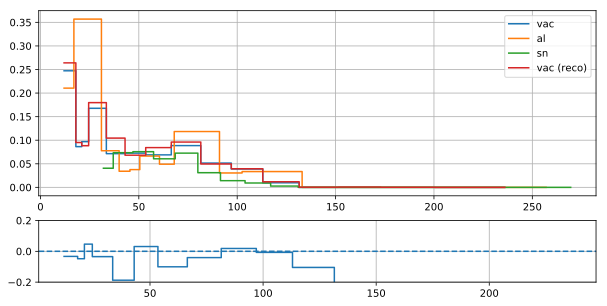

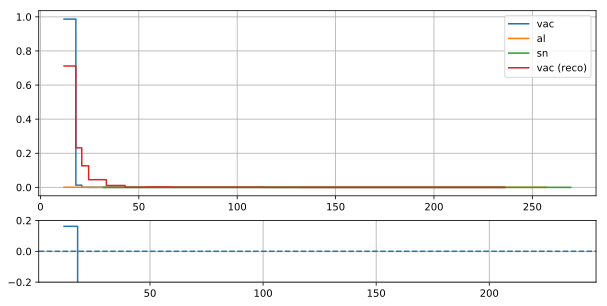

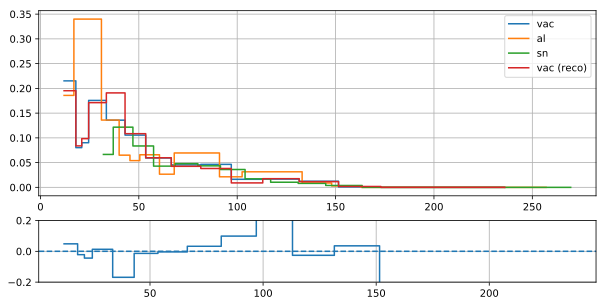

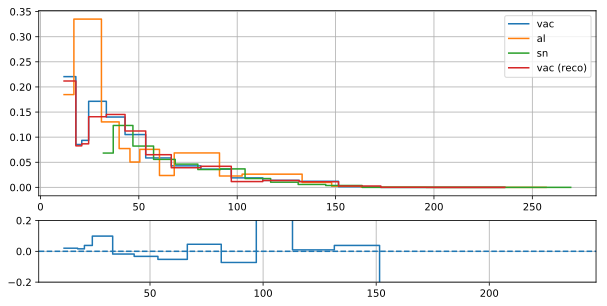

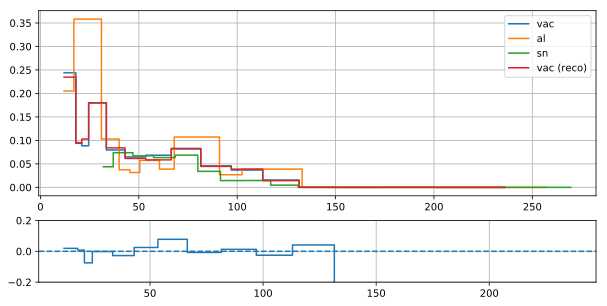

In [25]:
DECONV=False
plotPrediction(res, deconv_data_test, deconv_data_true_test, bins=bins, N=5)

## Measurement Data (Binned)

In [12]:
sys.path.insert(0, '../../csv/')
import plot_csv_support as pcs

inFolder = '../../csv/PTBMay18/Winkel/'
meas_data = pcs.getCombinedBins(inFolder, erlangen=False, large=True, angle=False, smallOpt=False)

### Create Dictionary

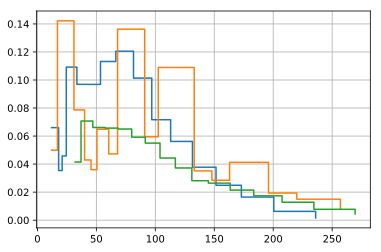

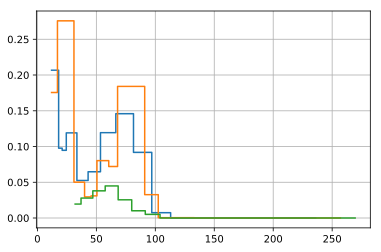

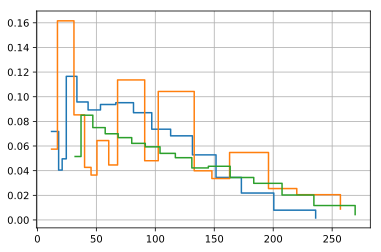

In [13]:
meas_data_dict = {'vac': [], 'al': [], 'sn': []}
titles = ['vac', 'al', 'sn']

# Normalize on first slot
for energy in meas_data['Slot1'].keys():
    energy_data = []
    norm = np.sum(meas_data['Slot1'][energy])
    for slot in range(3):
        meas_data_dict[titles[slot]].append( np.asarray(list(reversed(meas_data['Slot%d' % (slot + 1)][energy])), dtype=float) / norm )
        
# Plot examples
for idx in range(3):
    for t in titles:
        bins = binEdges[t]
        plt.step(bins[:-1], meas_data_dict[t][idx], where='post')
        plt.grid()
    plt.show()

### Measurement Evaluation

In [26]:
BINS_EVAL = 15
data_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x': np.hstack((np.asarray(meas_data_dict['al']), np.asarray(meas_data_dict['sn'])))},
    y=np.asarray(meas_data_dict['vac']),
    num_epochs=1,
    batch_size=15,
    shuffle=False)

res = estimator.predict(input_fn=data_input_fn)

Tensor("Cast:0", shape=(?, 32), dtype=float32) 16
[128, 128, 128]
Tensor("decoder/Abs:0", shape=(15, 1, 16), dtype=float32)
INFO:tensorflow:Restoring parameters from model_dir/modelAEelectron1/model.ckpt-436915


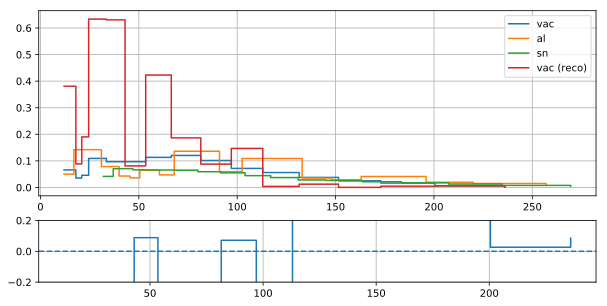

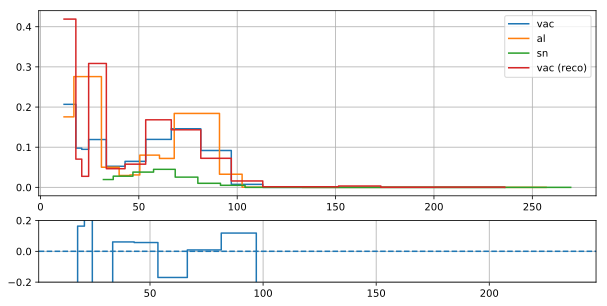

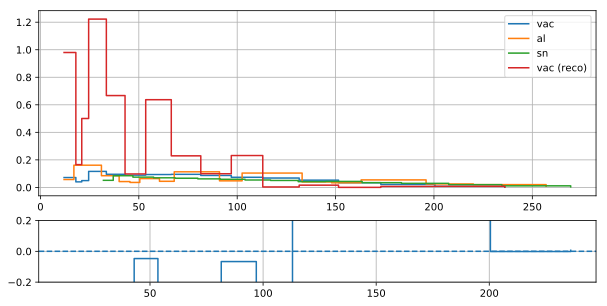

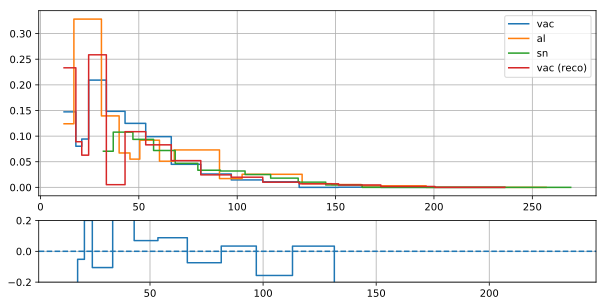

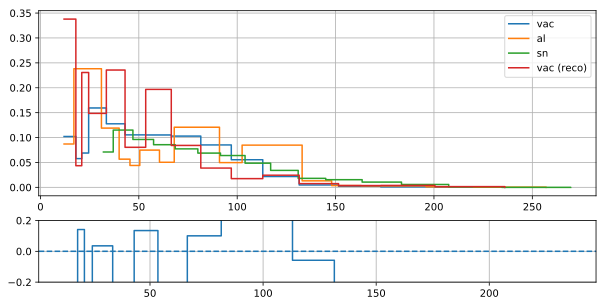

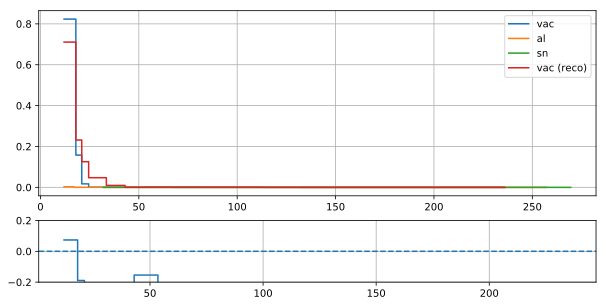

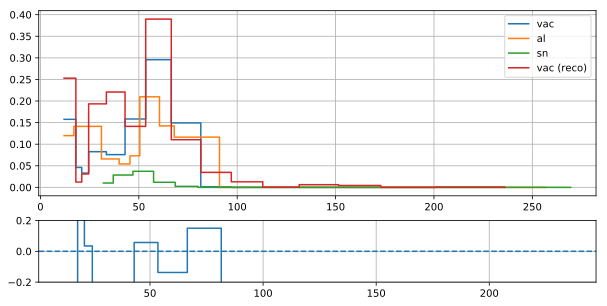

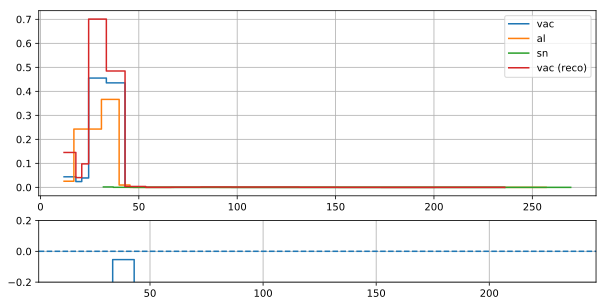

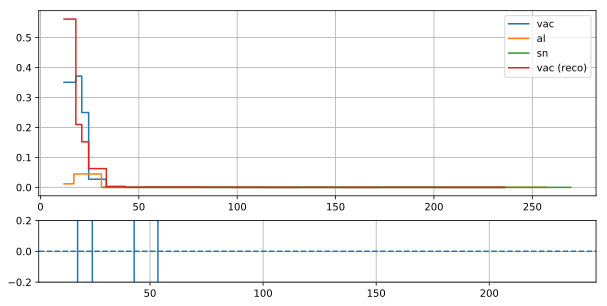

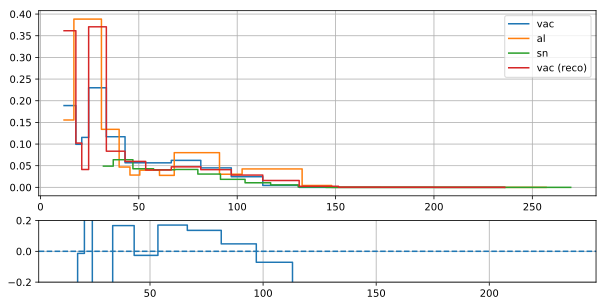

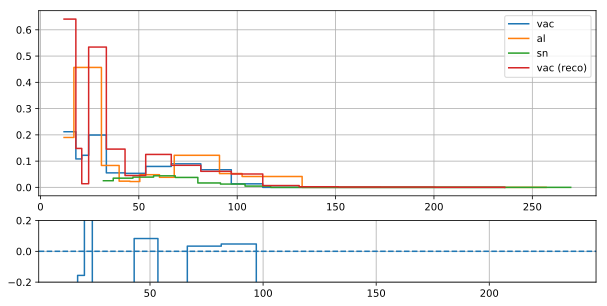

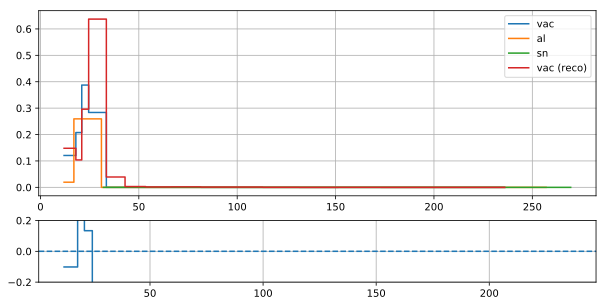

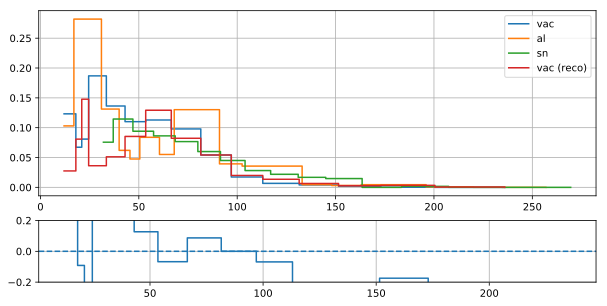

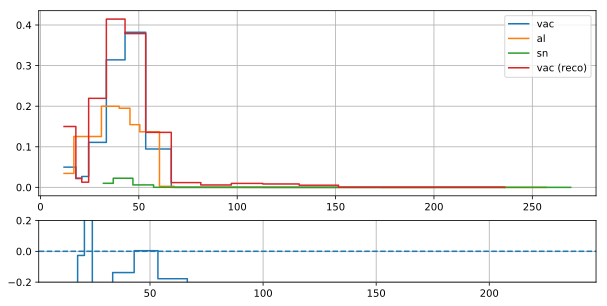

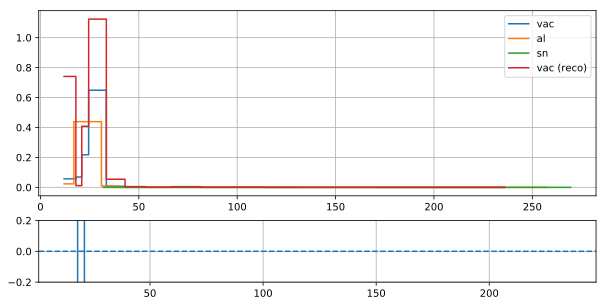

In [27]:
plotPrediction(res, meas_data_dict, meas_data_dict, bins, N=BINS_EVAL)